In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

datapath = '/Users/daniellee/Desktop/Data/Datasets/talkingdata_fraud/'

In [256]:
train = pd.read_csv(datapath+'train.csv', nrows=8000000)
test = pd.read_csv(datapath+'test.csv')
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [7]:
train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed'],
      dtype='object')

In [3]:
for col in ['app', 'device', 'os', 'channel']:
    print(col, train[col].unique().shape[0])

app 278
device 490
os 211
channel 158


In [6]:
train['is_attributed'].value_counts() / train.shape[0]

0    0.998298
1    0.001702
Name: is_attributed, dtype: float64

In [ ]:
# Build a random forest model using a sample of million datapoints 

sample_ids = np.random.choice(train['ip'].unique(), size=int(277396*0.05))
train_million = train[train.ip.isin(sample_ids)]

## EDA

In [ ]:
train_million.is_attributed.head()#.mean()

In [ ]:
train_million.query('is_attributed == 1')['app'].value_counts().head(10)

In [ ]:
train_million.query('is_attributed == 1')['device'].value_counts().head(10).plot(kind='bar')

In [ ]:
train_million.query('is_attributed == 0')['device'].value_counts().head(10).plot(kind='bar')

In [ ]:
train_million.query('is_attributed == 1')['os'].value_counts().head(10).plot(kind='bar')

In [ ]:
train_million.query('is_attributed == 0')['os'].value_counts().head(10).plot(kind='bar')

In [ ]:
train_million.query('is_attributed == 1')['channel'].value_counts().head(10).plot(kind='bar')

In [ ]:
train_million['click_time'] = pd.to_datetime(train_million['click_time'])
train_million['click_date'] = train_million.click_time.dt.date

In [ ]:
cnt_of_ips = train_million.ip.unique().shape[0]
date_stats = train_million.groupby('click_date')['is_attributed'].apply(lambda x: sum(x) * 1.0 / cnt_of_ips)

In [ ]:
date_stats.plot()

In [ ]:
cnt_of_ips = train_million.ip.unique().shape[0]
date_stats = train_million.groupby('click_time')['is_attributed'].apply(lambda x: sum(x) * 1.0 / cnt_of_ips)

In [ ]:
date_stats.reset_index().plot(x='click_time',y='is_attributed',figsize=(13,8), alpha=0.5)

In [ ]:
train_million['hour'] = train_million['click_time'].dt.hour
hour_stats = train_million.groupby('hour')['is_attributed'].apply(lambda x: sum(x) / len(x))

In [ ]:
hour_stats.plot(xticks=hour_stats.index)

In [ ]:
train_million['app'].unique().shape[0]

In [ ]:
train_million['device'].unique().shape[0]

In [ ]:
train_million['os'].unique().shape[0]

In [ ]:
train_million['channel'].unique().shape[0]

## Feature Engineering

In [ ]:
# Create datetime

test_copy = train_million.copy() 

In [4]:
def new_df_with_time(df):
    df['click_time'] = pd.to_datetime(df['click_time'])
    df['hour'] = df.click_time.dt.hour
    df['month'] = df.click_time.dt.month
    df['day'] = df.click_time.dt.day
    return df

In [5]:
def return_top_k_dummies(df, col, k=3):
    df_copy = df.copy()
    top_k_names = df_copy[col].value_counts().index[:k]
    df_copy[~df_copy[col].isin(top_k_names)] = -999
    return pd.get_dummies(df_copy[col])

In [6]:
def new_df_with_dummies(df):
    for var in ['app','device','os','channel']:
        dummies = return_top_k_dummies(df, var, 3)
        dummies.columns = [var + '_' + str(col) for col in dummies.columns]
        df = pd.concat([df,dummies],axis=1)    
    return df

In [7]:
test_cp = pd.concat([train,test], keys=['train','test'])

In [14]:
train['df'] = 'train'
test['df'] = 'test'
common_features = list(set(train.columns).intersection(set(test.columns)))
comb_df = pd.concat([train[common_features],test[common_features]])

In [15]:
comb_df = new_df_with_time(comb_df)
comb_df = new_df_with_dummies(comb_df)

## Build Classifier

In [16]:
comb_df

,click_time,df,os,ip,device,app,channel,hour,month,day,...,device_1,device_2,os_-999,os_13,os_17,os_19,channel_-999,channel_107,channel_265,channel_477
0,2017-11-06 14:32:21,train,13,83230,1,3,379,14,11,6,...,1,0,0,1,0,0,1,0,0,0
1,2017-11-06 14:33:34,train,19,17357,1,3,379,14,11,6,...,1,0,0,0,0,1,1,0,0,0
2,2017-11-06 14:34:12,train,13,35810,1,3,379,14,11,6,...,1,0,0,1,0,0,1,0,0,0
3,2017-11-06 14:34:52,train,13,45745,1,14,478,14,11,6,...,1,0,0,1,0,0,1,0,0,0
4,2017-11-06 14:35:08,train,13,161007,1,3,379,14,11,6,...,1,0,0,1,0,0,1,0,0,0
5,2017-11-06 14:36:26,train,16,18787,1,3,379,14,11,6,...,1,0,1,0,0,0,1,0,0,0
6,2017-11-06 14:37:44,train,23,103022,1,3,379,14,11,6,...,1,0,1,0,0,0,1,0,0,0
7,2017-11-06 14:37:59,train,19,114221,1,3,379,14,11,6,...,1,0,0,0,0,1,1,0,0,0
8,2017-11-06 14:38:10,train,13,165970,1,3,379,14,11,6,...,1,0,0,1,0,0,1,0,0,0
9,2017-11-06 14:38:23,train,22,74544,1,64,459,14,11,6,...,1,0,1,0,0,0,1,0,0,0


In [17]:
# Create train_X, train_y and test_X
train_X = comb_df[comb_df.df == 'train']
test_X = comb_df[comb_df.df == 'test']

In [67]:
test_X.columns

Index(['df', 'click_time', 'channel', 'app', 'device', 'os', 'ip', 'hour',
       'month', 'day', 'app_-999', 'app_3', 'app_9', 'app_12', 'device_-999',
       'device_0', 'device_1', 'device_2', 'os_-999', 'os_13', 'os_17',
       'os_19', 'channel_-999', 'channel_107', 'channel_265', 'channel_477'],
      dtype='object')

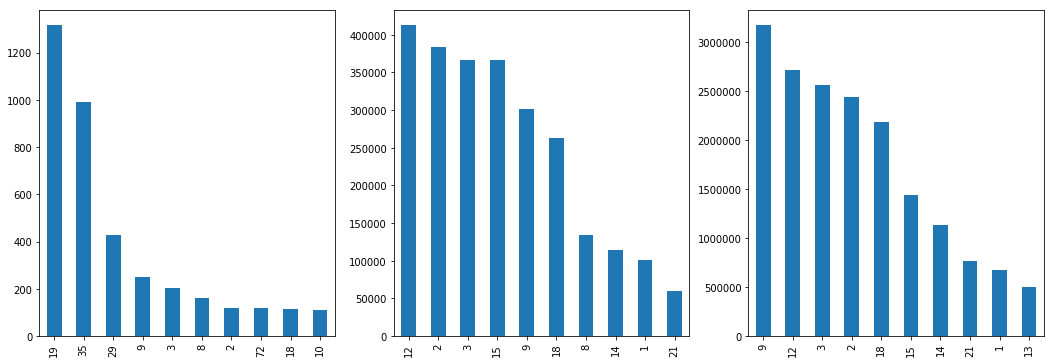

In [28]:
var_2_plot = 'app'
f, ax = plt.subplots(1,3,figsize=(18,6))
train.query('is_attributed == 1')[var_2_plot].value_counts().head(10).plot(kind='bar',ax=ax[0])
train.query('is_attributed == 0')[var_2_plot].value_counts().head(10).plot(kind='bar',ax=ax[1])
pd.concat([train[[var_2_plot]],test[[var_2_plot]]])[var_2_plot].value_counts().head(10).plot(kind='bar',ax=ax[2])

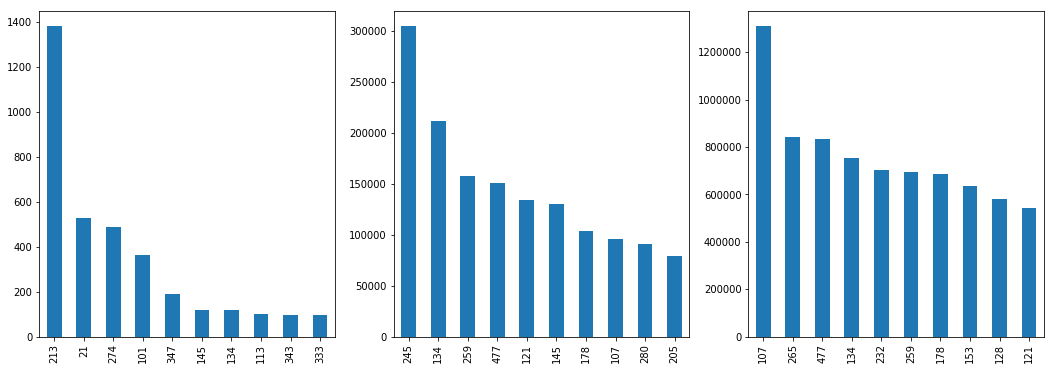

In [29]:
var_2_plot = 'channel'
f, ax = plt.subplots(1,3,figsize=(18,6))
train.query('is_attributed == 1')[var_2_plot].value_counts().head(10).plot(kind='bar',ax=ax[0])
train.query('is_attributed == 0')[var_2_plot].value_counts().head(10).plot(kind='bar',ax=ax[1])
pd.concat([train[[var_2_plot]],test[[var_2_plot]]])[var_2_plot].value_counts().head(10).plot(kind='bar',ax=ax[2])

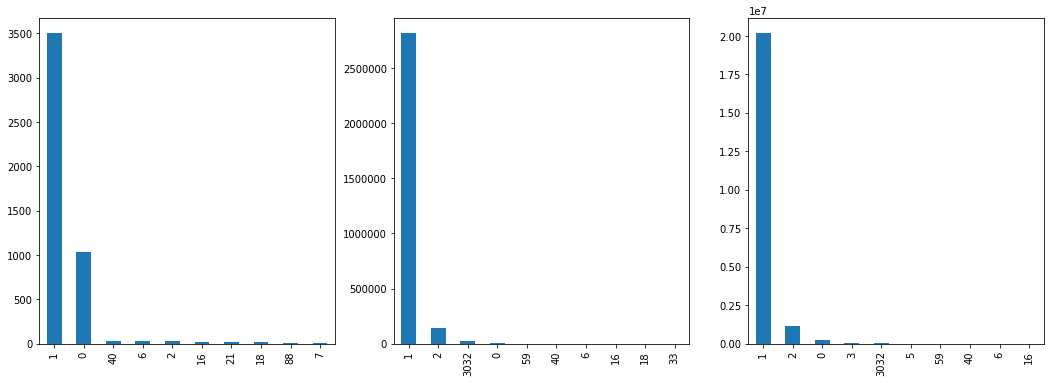

In [30]:
var_2_plot = 'device'
f, ax = plt.subplots(1,3,figsize=(18,6))
train.query('is_attributed == 1')[var_2_plot].value_counts().head(10).plot(kind='bar',ax=ax[0])
train.query('is_attributed == 0')[var_2_plot].value_counts().head(10).plot(kind='bar',ax=ax[1])
pd.concat([train[[var_2_plot]],test[[var_2_plot]]])[var_2_plot].value_counts().head(10).plot(kind='bar',ax=ax[2])

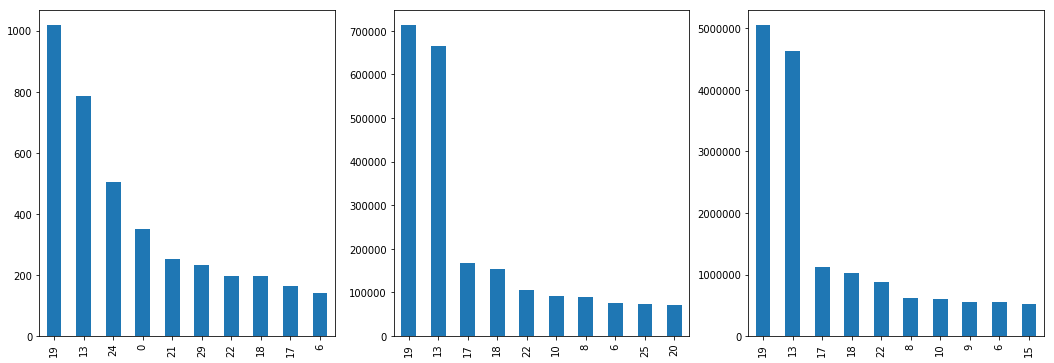

In [31]:
var_2_plot = 'os'
f, ax = plt.subplots(1,3,figsize=(18,6))
train.query('is_attributed == 1')[var_2_plot].value_counts().head(10).plot(kind='bar',ax=ax[0])
train.query('is_attributed == 0')[var_2_plot].value_counts().head(10).plot(kind='bar',ax=ax[1])
pd.concat([train[[var_2_plot]],test[[var_2_plot]]])[var_2_plot].value_counts().head(10).plot(kind='bar',ax=ax[2])

In [68]:
train_X.columns

Index(['df', 'click_time', 'channel', 'app', 'device', 'os', 'ip', 'hour',
       'month', 'day', 'app_-999', 'app_3', 'app_9', 'app_12', 'device_-999',
       'device_0', 'device_1', 'device_2', 'os_-999', 'os_13', 'os_17',
       'os_19', 'channel_-999', 'channel_107', 'channel_265', 'channel_477'],
      dtype='object')

In [20]:
feats_to_remove = ['df', 'click_time', 'channel', 'app', 'device', 'os', 'ip']
train_X = train_X.drop(feats_to_remove, axis=1)
train_y = train['is_attributed']

test_X = test_X.drop(feats_to_remove, axis=1)
test_y = test['click_id']

In [ ]:
set(train_X.columns) == set(test_X.columns)

In [71]:
train_X.columns

Index(['hour', 'month', 'day', 'app_-999', 'app_3', 'app_9', 'app_12',
       'device_-999', 'device_0', 'device_1', 'device_2', 'os_-999', 'os_13',
       'os_17', 'os_19', 'channel_-999', 'channel_107', 'channel_265',
       'channel_477'],
      dtype='object')

In [72]:
test_X.columns

Index(['hour', 'month', 'day', 'app_-999', 'app_3', 'app_9', 'app_12',
       'device_-999', 'device_0', 'device_1', 'device_2', 'os_-999', 'os_13',
       'os_17', 'os_19', 'channel_-999', 'channel_107', 'channel_265',
       'channel_477'],
      dtype='object')

In [82]:
from sklearn.ensemble import RandomForestClassifier as RFM

rfm = RFM()
rfm.fit(train_X, train_y)
rfm_predict = rfm.predict(test_X)

submission_path = '/Users/daniellee/Dropbox/Jupyter/Kaggle/talkingdata_fraud/submissions/'

test['is_attributed'] = rfm_predict
submission_df = test[['click_id','is_attributed']]
submission_df.to_csv(submission_path+'submission_01_basic_features_rfm.csv')

## Approach #2

In [18]:
from sklearn.linear_model import SGDClassifier

sgd = (
    SGDClassifier(
        class_weight={1:10}
    )
)

In [21]:
sgd.fit(train_X, train_y)

/Users/daniellee/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight={1: 10}, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [28]:
sgd_predict = sgd.predict(test_X)

In [37]:
test['sgd_predict'] = sgd_predict

In [39]:
submission_df = test[['click_id','sgd_predict']]
submission_df.columns = ['click_id','is_attributed']
submission_df.to_csv(submission_path+'submission_02_basic_features_sgd_weigthed.csv')

NameError: name 'submission_path' is not defined

In [40]:
submission_path = '/Users/daniellee/Dropbox/Jupyter/Kaggle/talkingdata_fraud/submissions/'


In [42]:
test.shape

(18790469, 9)

In [44]:
submission_df.shape

(18790469, 2)

In [41]:
submission_df.to_csv(submission_path+'submission_02_basic_features_sgd_weigthed.csv')

## Approach #3 - EDA

In [275]:
ip_attributed = train[train.is_attributed == 1]['ip'].unique()

In [277]:
ip_attributed.shape

(13272,)

In [81]:
# Does order matter? <= Yes it does!

In [276]:
train['row_number'] = train.groupby('ip').cumcount()

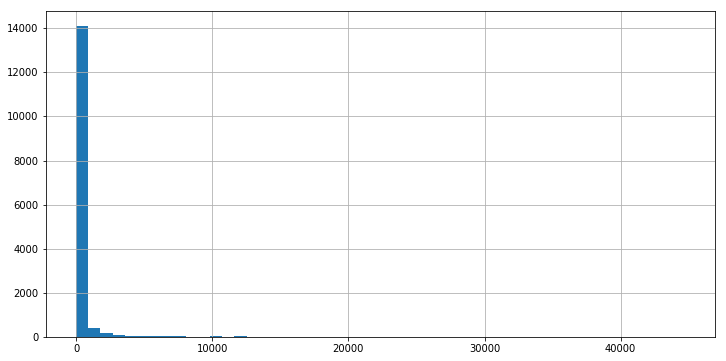

In [278]:
train[train.is_attributed == 1]['row_number'].hist(figsize=(12,6),bins=50)

In [279]:
train[train.is_attributed == 1]['row_number'].value_counts() / train.is_attributed.sum()

0        0.249736
1        0.113672
2        0.047094
3        0.025297
4        0.018560
5        0.013078
6        0.011889
7        0.009577
9        0.008388
8        0.008124
10       0.008058
11       0.007992
13       0.007926
12       0.007332
14       0.005945
18       0.005878
15       0.005680
17       0.005614
16       0.005284
19       0.005152
20       0.005020
23       0.004756
27       0.004425
21       0.004227
29       0.004161
24       0.003897
25       0.003831
26       0.003831
31       0.003633
37       0.003567
           ...   
924      0.000066
964      0.000066
1004     0.000066
7175     0.000066
1052     0.000066
23591    0.000066
9256     0.000066
1068     0.000066
1076     0.000066
1116     0.000066
820      0.000066
804      0.000066
2621     0.000066
796      0.000066
580      0.000066
628      0.000066
636      0.000066
2701     0.000066
668      0.000066
676      0.000066
2725     0.000066
2733     0.000066
700      0.000066
2749     0.000066
8896     0

In [ ]:
# Do user's number of clicks convey anything about their attribution likelihood? <= Yes 

ip_attributed = train.loc[train.is_attributed == 1, 'ip'].unique()

In [ ]:
train_ip_attributed = train.loc[train.ip.isin(ip_attributed)].groupby('ip')['os'].count()

In [ ]:
train_ip_attributed.hist(bins=100, figsize=(18,8))

In [ ]:
train_ip_attributed.value_counts()

In [254]:
train[train.ip == ip_attributed[7]].head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,attribute_ip,date,timestamp,click_time_no_seconds
2474,57546,12,1,22,245,2017-11-06 16:00:03,NaN,0,1,2017-11-06,2018-03-10 16:00:03,2017-11-06 16:00:00
2522,57546,18,1,22,121,2017-11-06 16:00:03,NaN,0,1,2017-11-06,2018-03-10 16:00:03,2017-11-06 16:00:00
2649,57546,15,1,22,245,2017-11-06 16:00:03,NaN,0,1,2017-11-06,2018-03-10 16:00:03,2017-11-06 16:00:00
5282,57546,29,1,41,213,2017-11-06 16:00:07,2017-11-06 16:03:51,1,1,2017-11-06,2018-03-10 16:00:07,2017-11-06 16:00:00
52843,57546,12,1,22,245,2017-11-06 16:00:57,NaN,0,1,2017-11-06,2018-03-10 16:00:57,2017-11-06 16:00:00


In [128]:
test['click_time'].max()

'2017-11-10 15:00:00'

In [129]:
test['click_time'].min()

'2017-11-10 04:00:00'

In [127]:
train['click_time'].max()

'2017-11-06 17:28:00'

## EDA - Attribute Individuals vs Non-Attribute Individuals

In [269]:
train['attribute_ip'] = 0

In [270]:
train.loc[train.ip.isin(ip_attributed),'attribute_ip'] = 1

In [271]:
ip_count = train.groupby('ip')['ip','attributed_time','attribute_ip'].count().reset_index(drop=True)

In [272]:
ip_count.drop('ip',axis=1,inplace=True)

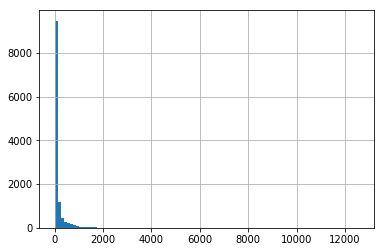

In [273]:
ip_count[ip_count.attributed_time == 1]['attribute_ip'].hist(bins=100)

(array([  3.51353790e-01,   1.23126210e-01,   8.48125381e-02,
          9.86577060e-02,   1.48030097e-01,   1.34010776e-01,
          8.42900789e-02,   2.97801725e-02,   5.13751514e-03,
          1.74153056e-04]),
 array([ 0.        ,  0.94395455,  1.8879091 ,  2.83186365,  3.77581821,
         4.71977276,  5.66372731,  6.60768186,  7.55163641,  8.49559096,
         9.43954551]),
 <a list of 10 Patch objects>)

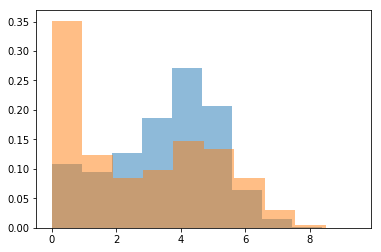

In [274]:
plt.hist(np.log(ip_count[ip_count.attributed_time == 0]['attribute_ip'].values), normed=True, alpha=0.5)#.hist(bins=100)
plt.hist(np.log(ip_count[ip_count.attributed_time == 1]['attribute_ip'].values), normed=True, alpha=0.5)

Np log on count may help differentiate individuals who are likely to be attribute vs individuals who may not be. 

## EDA Across Time

In [262]:
train['click_time'] = train['click_time'].astype('str')

In [263]:
train['click_time_no_seconds'] = train['click_time'].map(lambda x: x[:-3])

In [264]:
train['click_time_no_seconds'] = pd.to_datetime(train['click_time_no_seconds'])

In [265]:
click_rate_per_timestamp = train.groupby('click_time_no_seconds')['is_attributed'].apply(lambda x: sum(x) / len(x))

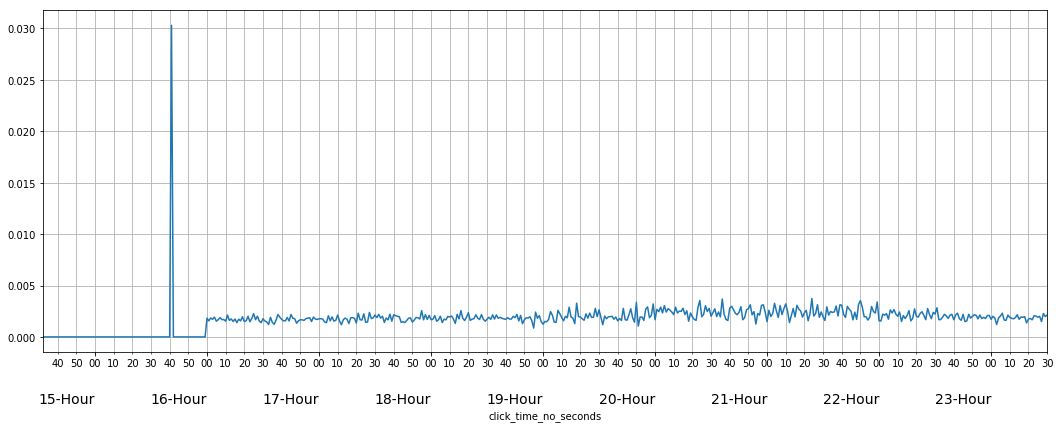

In [268]:
import matplotlib.dates as dates 

f, ax = plt.subplots()
click_rate_per_timestamp.plot(figsize=(18,7), ax=ax)

ax.xaxis.set_minor_locator(dates.MinuteLocator(byminute=(list(range(0,60,10))), interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%M'))
ax.xaxis.grid(True, which='minor')
ax.yaxis.grid()

ax.xaxis.set_major_locator(dates.HourLocator(byhour=(range(14,24,1)), interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%H-Hour'))
plt.xticks(fontsize=14, rotation=0)

plt.show()